In [1]:
# Standard imports
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Built-in library
import itertools
import re
import json
from typing import List, Union, Dict, Tuple

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
dataframe = pd.read_csv("Cleaned_diamond_data.csv")
dataframe1 = dataframe.copy()
dataframe1.head()

,Month,Manager Name,I/O,Barcode,Org Crts,ASK Purity,Final Purity,Purity group,ASK Color,Final Color,Color Group,Ask Crts,Fin Crts,Size Group,ASK P,Final Pointer,Final Value,F value,Jiram Value,Pointer Diff,Ask P Diff,Ask Size,S Purity,new_column,Diamond Price
0,Jan-23,Inhouse,Inside,222625-37.1,0.209,N4,N4,I1 & above,G,G,G-J,0.180,0.180,0.18-0.299,0.18,0.18,76.5,0.0,0.0,0.00,0.00,0.18 - 0.299,SI1 & DOWN,USA,7650.0
1,Jan-23,Inhouse,Inside,222625A-6.1,0.171,I2,I2,I1 & above,G,G,G-J,0.140,0.128,0.14-0.179,0.14,0.12,60.160000000000004,0.0,0.0,0.00,-0.02,0.14 - 0.179,SI1 & DOWN,Belgium,4800
2,Jan-23,Inhouse,Inside,222645-607,0.173,I2-,I2-,I1 & above,G,H,G-J,0.142,0.132,0.14-0.179,0.14,0.13,49.5,0.0,0.0,-0.01,-0.01,0.14 - 0.179,SI1 & DOWN,Belgium,5395.999999999999
3,Jan-23,Inhouse,Inside,222665-486,0.625,N2,N2,I1 & above,I,I,G-J,0.489,0.465,0.3 & up,0.48,0.46,627.75,0.0,0.0,-0.02,-0.02,0.3 & Up,SI1 & DOWN,UAE,66015.0
4,Jan-23,Diamcor Mining,Outside,227530-1-01,0.006,VS2,VS1,VS1-VS2,G,H,G-J,0.005,0.005,0.019 & below,0.00,0.00,2.725,0.0,0.0,0.00,0.00,0 - 0.019,IF TO VS2,Hong Kong,252.5


In [3]:
dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577046 entries, 0 to 577045
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Month          577046 non-null  object 
 1   Manager Name   577046 non-null  object 
 2   I/O            577046 non-null  object 
 3   Barcode        577046 non-null  object 
 4   Org Crts       577046 non-null  float64
 5   ASK Purity     577046 non-null  object 
 6   Final Purity   577046 non-null  object 
 7   Purity group   577046 non-null  object 
 8   ASK Color      577046 non-null  object 
 9   Final Color    577046 non-null  object 
 10  Color Group    577046 non-null  object 
 11  Ask Crts       577046 non-null  float64
 12  Fin Crts       577046 non-null  float64
 13  Size Group     577046 non-null  object 
 14  ASK P          577046 non-null  float64
 15  Final Pointer  577046 non-null  float64
 16  Final Value    577046 non-null  object 
 17  F value        577046 non-nul

### Splitting the dataset into numerical and categorical variables

In [4]:
dataframe1["Diamond Price"] = pd.to_numeric(dataframe1["Diamond Price"], errors='coerce')
dataframe1["Diamond Price"].isna().sum()

4080

In [5]:
dataframe1["Diamond Price"] = dataframe1["Diamond Price"].fillna(dataframe1['Diamond Price'].median())

In [6]:
dataframe1["Final Value"] = pd.to_numeric(dataframe1["Final Value"], errors='coerce')
dataframe1["Final Value"].isna().sum()

353

In [7]:
dataframe1["Final Value"] = dataframe1["Final Value"].fillna(dataframe1['Final Value'].median())

In [8]:
# Splitting it into two lists
num_variables = [
    col
    for col in dataframe1.columns
    if dataframe1[col].dtype != "O" and col != "Diamond Price"
]

cat_variables = [
    col
    for col in dataframe1.columns
    if dataframe1[col].dtype == "O" and col != "Diamond Price"
]
num_variables, cat_variables, len(num_variables), len(cat_variables)

(['Org Crts',
  'Ask Crts',
  'Fin Crts',
  'ASK P',
  'Final Pointer',
  'Final Value',
  'F value',
  'Jiram Value',
  'Pointer Diff',
  'Ask P Diff'],
 ['Month',
  'Manager Name',
  'I/O',
  'Barcode',
  'ASK Purity',
  'Final Purity',
  'Purity group',
  'ASK Color',
  'Final Color',
  'Color Group',
  'Size Group',
  'Ask Size',
  'S Purity',
  'new_column'],
 10,
 14)

In [9]:
# Splitting it into two datasets
df_num_variables = dataframe1.select_dtypes(exclude='object')
df_cat_variables = dataframe1.select_dtypes(include='object')
df_num_variables.shape, df_cat_variables.shape

((577046, 11), (577046, 14))

#### Analyzing the numerical variables
Correlation matrix and Heatmap to visualize correlation between numerical variables 

In [10]:
df_num_variables.describe()

,Org Crts,Ask Crts,Fin Crts,ASK P,Final Pointer,Final Value,F value,Jiram Value,Pointer Diff,Ask P Diff,Diamond Price
count,577046.000000,577046.000000,577046.000000,577046.000000,577046.000000,577046.000000,577046.000000,577046.000000,577046.000000,577046.000000,577046.000000
mean,0.094059,0.066747,0.064985,0.064856,0.060687,37.858856,-0.084602,-0.084602,-0.003270,-0.004129,3912.384870
std,0.106636,0.069845,0.070029,0.070167,0.070358,56.355962,2.270425,2.270425,0.007117,0.006431,5689.253997
min,0.003000,0.001000,0.001000,0.000000,0.000000,0.000000,-518.180000,-518.180000,-1.850000,-0.880000,0.000000
25%,0.018000,0.010000,0.012000,0.010000,0.010000,5.500000,0.000000,0.000000,-0.010000,-0.010000,555.000000
50%,0.056000,0.045000,0.041000,0.040000,0.040000,17.325000,0.000000,0.000000,0.000000,0.000000,1976.000000
75%,0.133000,0.100000,0.095000,0.100000,0.090000,50.985000,0.000000,0.000000,0.000000,0.000000,5272.500000
max,2.429000,1.220000,1.212000,1.220000,1.210000,2742.375000,124.260000,124.260000,0.670000,0.670000,645075.000000


In [11]:
corr = df_num_variables.corr()
corr

,Org Crts,Ask Crts,Fin Crts,ASK P,Final Pointer,Final Value,F value,Jiram Value,Pointer Diff,Ask P Diff,Diamond Price
Org Crts,1.000000,0.967560,0.967606,0.966168,0.965302,0.889229,-0.079669,-0.079669,0.133304,0.038084,0.883398
Ask Crts,0.967560,1.000000,0.997492,0.999058,0.995423,0.913877,-0.063919,-0.063919,0.116352,0.005856,0.908301
Fin Crts,0.967606,0.997492,1.000000,0.996761,0.998148,0.916859,-0.055388,-0.055388,0.151888,0.060838,0.908367
ASK P,0.966168,0.999058,0.996761,1.000000,0.995003,0.912220,-0.063748,-0.063748,0.106552,-0.009065,0.906555
Final Pointer,0.965302,0.995423,0.998148,0.995003,1.000000,0.916581,-0.048837,-0.048837,0.170471,0.082364,0.906245
Final Value,0.889229,0.913877,0.916859,0.912220,0.916581,1.000000,-0.036888,-0.036888,0.146077,0.072511,0.975941
F value,-0.079669,-0.063919,-0.055388,-0.063748,-0.048837,-0.036888,1.000000,1.000000,0.073607,0.091541,-0.059983
Jiram Value,-0.079669,-0.063919,-0.055388,-0.063748,-0.048837,-0.036888,1.000000,1.000000,0.073607,0.091541,-0.059983
Pointer Diff,0.133304,0.116352,0.151888,0.106552,0.170471,0.146077,0.073607,0.073607,1.000000,0.702466,0.080353
Ask P Diff,0.038084,0.005856,0.060838,-0.009065,0.082364,0.072511,0.091541,0.091541,0.702466,1.000000,0.038634


<function matplotlib.pyplot.show(close=None, block=None)>

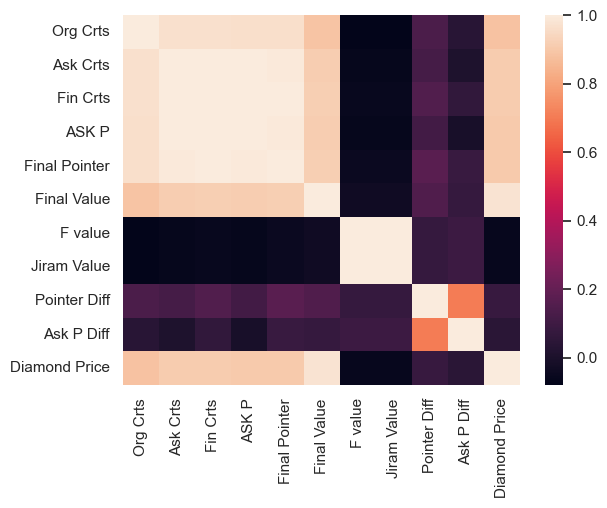

In [12]:
sns.heatmap(corr)
plt.show

Split numerical variables into discrete and continuous variables

In [13]:
UNIQUE_THRESH = 20

discrete_variables = [
    col for col in dataframe1[num_variables] if dataframe1[col].nunique() <= UNIQUE_THRESH
]
continuous_variables = [
    col for col in dataframe1[num_variables] if dataframe1[col].nunique() > UNIQUE_THRESH
]
discrete_variables, continuous_variables

([],
 ['Org Crts',
  'Ask Crts',
  'Fin Crts',
  'ASK P',
  'Final Pointer',
  'Final Value',
  'F value',
  'Jiram Value',
  'Pointer Diff',
  'Ask P Diff'])

In [14]:
discrete = dataframe1[discrete_variables]
continuous = dataframe1[continuous_variables]
discrete.shape, continuous.shape

((577046, 0), (577046, 10))

Histograms and boxplots showing distribution of continuous numerical variables

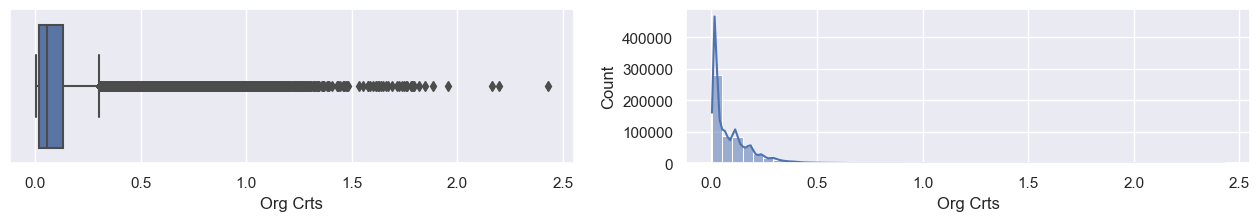

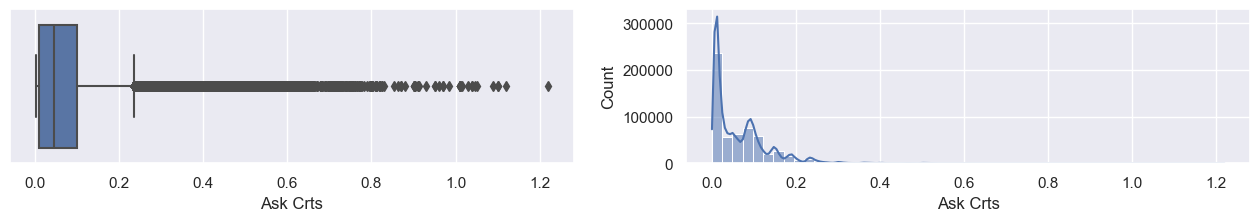

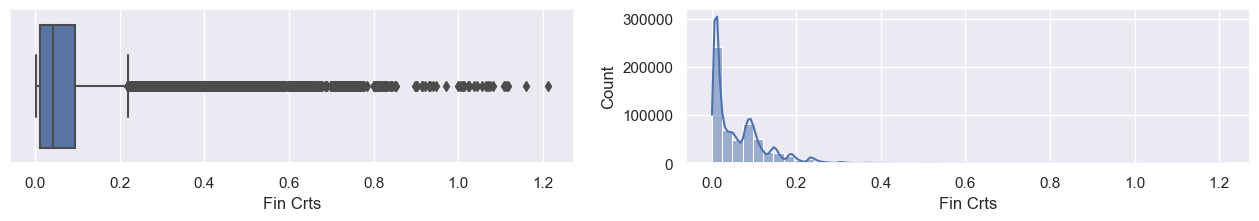

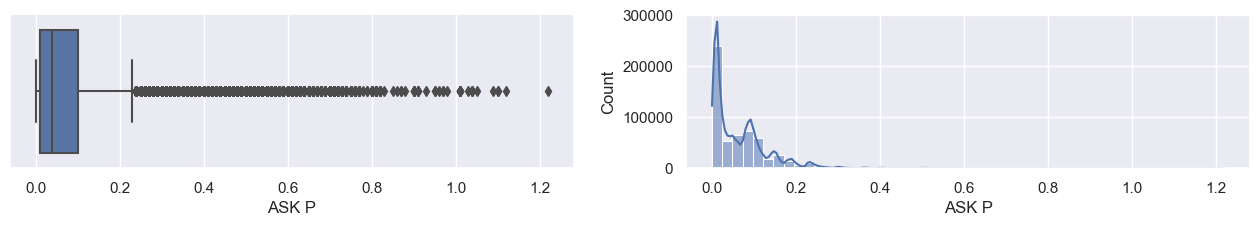

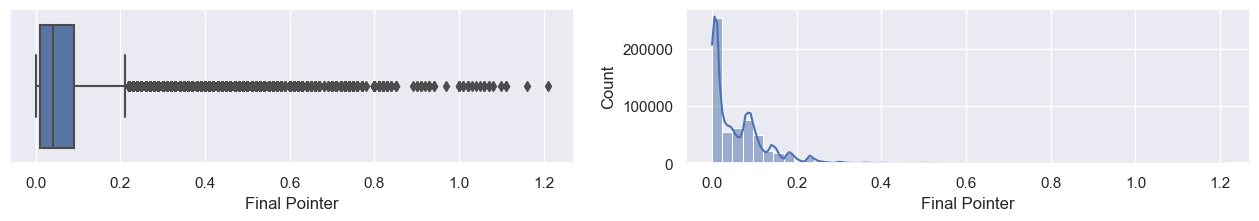

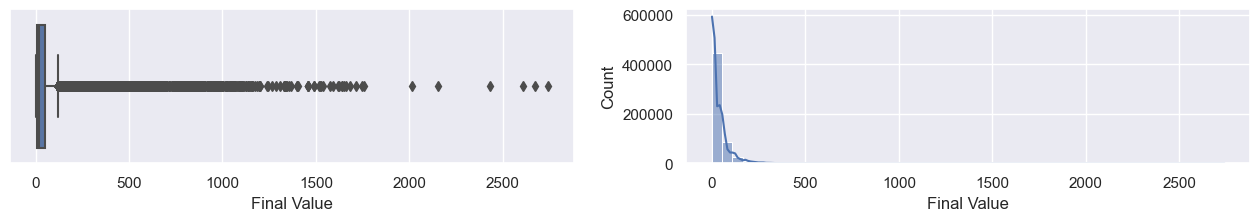

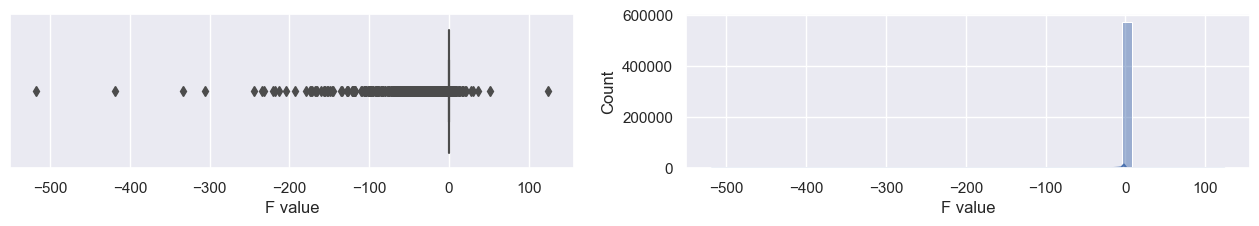

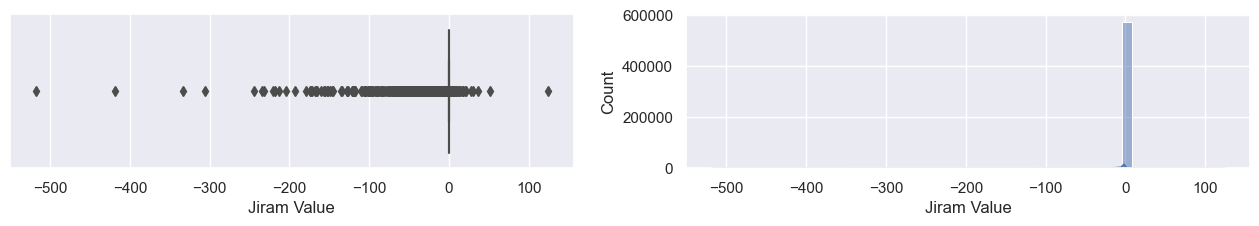

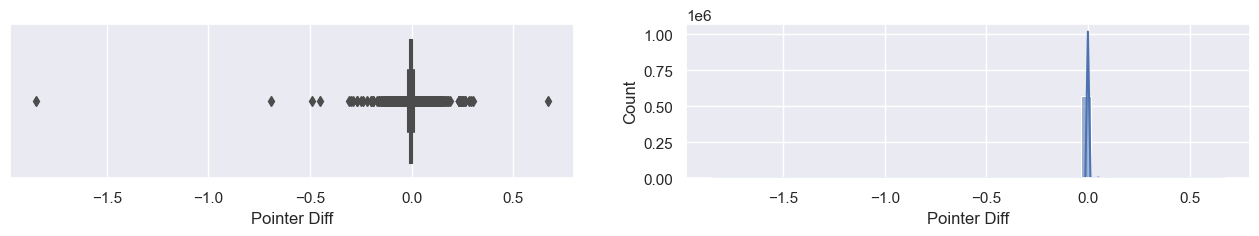

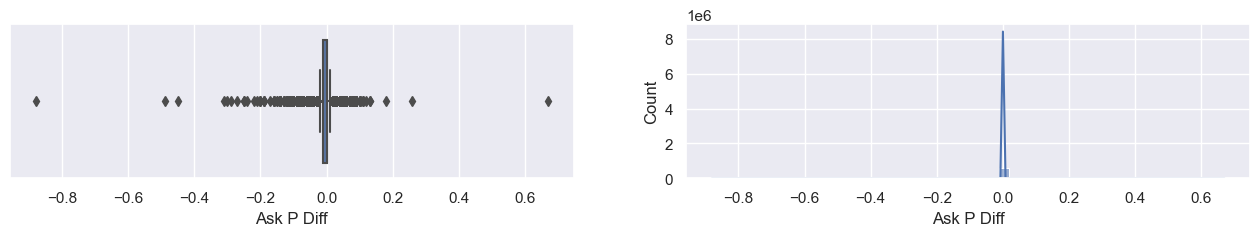

In [15]:
def plot_box_hist(num):
    # assigning a graph to each ax
    fig, (ax_box, ax_hist) = plt.subplots(ncols=2, figsize=(16,2))
    sns.boxplot(x=num, data=continuous, ax=ax_box)
    sns.histplot(x=num, data=continuous, bins=50, kde=True, ax=ax_hist)
    plt.show()


for num in continuous_variables:
    plot_box_hist(num)

#### Analyzing the categorical variable

In [16]:
df_cat_variables.describe()

,Month,Manager Name,I/O,Barcode,ASK Purity,Final Purity,Purity group,ASK Color,Final Color,Color Group,Size Group,Ask Size,S Purity,new_column
count,577046,577046,577046,577046,577046,577046,577046,577046,577046,577046,577046,577046,577046,577046
unique,12,28,2,577042,24,24,4,21,17,4,7,7,3,7
top,Jun-23,Inhouse,Outside,233495-575-02,VS1,VS1,VS1-VS2,G,G,G-J,0.019 & below,0 - 0.019,SI1 & DOWN,Japan
freq,64558,206291,370756,2,95263,117821,177795,271874,264808,498116,185609,185609,314925,82713


In [17]:
def plot_counts(
    data: pd.DataFrame,
    features: list[str])-> "Plot":
    """This returns a count plot of all the specified features."""

    num_cols = len(features)
    fig, axes = plt.subplots(num_cols // 2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, col in enumerate(features):
            sns.countplot(x=col, data=data, ax=axes[i])
            axes[i].set_title(f'Count Plot of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            
    plt.tight_layout()
    plt.show()

In [18]:
# plot_counts(
#     data=df_cat_variables, features=cat_variables
# )

# SOLUTION TO BUSINESS QUESTIONS

Stakeholders want to know how many diamonds are produced inside the factory or outside means outsourcing.


In [19]:
dataframe1["I/O"].value_counts()

Outside    370756
Inside     206290
Name: I/O, dtype: int64

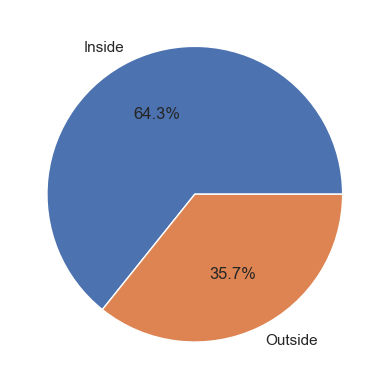

In [20]:
size = dataframe1["I/O"].value_counts(normalize=True).to_list()
labels = dataframe1["I/O"].unique().tolist()
plt.pie(size, labels=labels, autopct='%1.1f%%')
plt.show()

What Size of diamond is most produced and what is the comparison between before polishing and after polishing the diamond.

In [21]:
dataframe1["Size Group"].value_counts().sort_values(ascending= False)

0.019 & below    185609
0.08-0.139       139589
0.02-0.049       107155
0.05-0.079        65663
0.14-0.179        36798
0.18-0.299        35887
0.3 & up           6345
Name: Size Group, dtype: int64

In [22]:
most_produced_size_of_diamond = dataframe1["Size Group"].value_counts().sort_values(ascending= False)[0]
print(f"The most produced diamond size is 0.019 & below with value_count of {most_produced_size_of_diamond}")

The most produced diamond size is 0.019 & below with value_count of 185609


How Jiram weight loss affected the price of the product

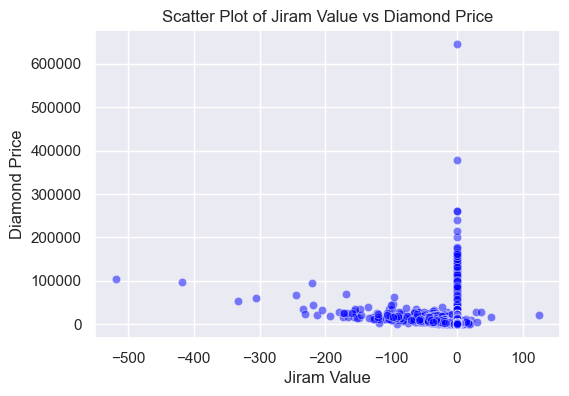

In [24]:
plt.figure(figsize=(6,4))

# Plot scatter plot using seaborn
sns.scatterplot(x=dataframe1['Jiram Value'], y=dataframe1['Diamond Price'], data=dataframe1, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Jiram Value')
plt.ylabel('Diamond Price')
plt.title('Scatter Plot of Jiram Value vs Diamond Price')

# Show plot
plt.show()